<a href="https://colab.research.google.com/github/nbalatamu/Hybrid-Dynamic-Models-for-Species-Dynamics/blob/main/Simulation_Parameters_Reproducibility_Species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we probe the reproducibility of model parameters and its dependence on the number of species in the community.

In the simulation data, we have 100 species. We will train our hybrid dynamic model with 50, 60, 70, 80, 90 and 100 species. We will look at the reproducibility of the community matrix A.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from tqdm.notebook import tqdm
import time
from sklearn.metrics import r2_score

%matplotlib inline

In [ ]:
!pip install torchdiffeq

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from torchdiffeq import odeint_adjoint
import time

In [ ]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

set_random_seeds()

#Import Data

In [ ]:
# Load the dictionary from the pickle file
with open('results_simulation.pkl', 'rb') as f:
    sim_results = pickle.load(f)

In [ ]:
key = list(sim_results.keys())
sim_data = 1

result = sim_results[sim_data]

e = result['e'].transpose(0, 1)
x = result['pred_y'].squeeze(1)
t = result['t']

In [ ]:
def data_split(x, e, test_size, val_size):

  #This function splits the data into train, validation, and test sets

  train_size = x.shape[0] - val_size - test_size

  train_x, train_e = x[:train_size], e[:train_size]
  val_x, val_e = x[train_size:train_size+val_size], e[train_size:train_size+val_size]
  test_x, test_e = x[train_size+val_size:], e[train_size+val_size:]

  return train_x, val_x, test_x, train_e, val_e, test_e

In [ ]:
def get_batch(train_time_points, train_x, train_e, batch_time = 12, batch_size = 8):
  s = torch.from_numpy(np.random.choice(np.arange(train_time_points - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = train_x[s]  # (batch_size, 1, emb)
  batch_t = t_train[:batch_time]  # (T)
  batch_y = torch.stack([train_x[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  batch_e = torch.stack([train_e[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, emb)
  return batch_y0, batch_t, batch_y, batch_e

In [ ]:
# Define the combined ODE model
class CombinedODEModel(nn.Module):
    def __init__(self, n, m, t_step):
        super(CombinedODEModel, self).__init__()
        self.n = n
        self.m = m
        self.t_step = t_step

        self.net_1 = nn.Linear(n, m)
        self.net_2 = nn.Linear(m, m, bias=False)
        self.net_3 = nn.Sequential(
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU()
        )

        self.e = None  # Placeholder for control variables

    def set_control_variables(self, e):
        self.e = e

    def forward(self, t, x):
        # Get the control variables at the current time step for all batches
        t_index = int(t.item() / self.t_step)
        e_t = self.e[t_index, :, :]
        return x * (self.net_1(e_t) + self.net_2(x) + self.net_3(x))

In [ ]:
def train_and_optimize_model(model_class,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_val, train_time_points, val_time_points, val_x,
                             niters=100, early_stopping_patience=20, early_stopping_min_delta=1e-4, model_args=None):

    best_val_loss = float('inf')
    best_hyperparams = None
    best_model_state = None

    for batch_time, batch_size, lr in hyperparameters:
        print(f"Training with batch_time={batch_time}, batch_size={batch_size}, lr={lr}")

        # Create the model
        if model_args:
          print("Model args:", model_args)
          model = model_class(model_args[0], model_args[1], model_args[2]) # Unpack arguments if provided
        else:
          model = model_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loss = []
        val_loss = []

        best_epoch_val_loss = float('inf')
        patience_counter = 0

        for iter in tqdm(range(niters + 1)):
            # Train loss
            optimizer.zero_grad()
            batch_y0, batch_t, batch_y, batch_e = get_batch(train_time_points, train_x, train_e, batch_time, batch_size)
            model.set_control_variables(batch_e)
            y_pred = odeint_adjoint(model, batch_y0, batch_t, rtol=1e-3, atol=1e-4, method='euler')
            loss = torch.mean(torch.square(y_pred - batch_y))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            # Val loss
            with torch.no_grad():
                model.set_control_variables(e.unsqueeze(1))
                y_pred_val = odeint_adjoint(model, x.unsqueeze(1)[0, :, :], t_val, rtol=1e-3, atol=1e-4, method='euler')
                val_loss_value = torch.mean(torch.square(y_pred_val[train_time_points:,:,:] - val_x.unsqueeze(1)))
                val_loss.append(val_loss_value.item())

            if torch.isnan(val_loss_value):
                print(f"NaN detected for batch_time={batch_time}, batch_size={batch_size}, lr={lr} at epoch {iter}")
                break

            if val_loss_value < best_epoch_val_loss - early_stopping_min_delta:
                best_epoch_val_loss = val_loss_value
                patience_counter = 0
                if val_loss_value < best_val_loss:
                    best_val_loss = val_loss_value
                    best_hyperparams = {'batch_time': batch_time, 'batch_size': batch_size, 'learning_rate': lr}
                    best_model_state = model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {iter}")
                break

        print(f"Best Val Loss after training: {best_epoch_val_loss}")

        plt.figure(figsize=(4, 2))
        plt.plot(train_loss, label='train')
        plt.plot(val_loss, label='val')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    #print(f"Best hyperparameters: {best_hyperparams}, Best validation loss: {best_val_loss}")

    return best_model_state, best_hyperparams, best_val_loss

In [ ]:
key

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

------------------------------Working on Simulation Data:  12 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 589
Best Val Loss after training: 0.0015685734106227756


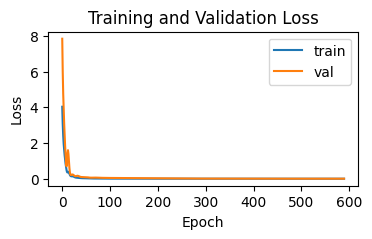

Test loss for 12: 0.004305651877075434
------------------------------Working on Simulation Data:  12 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 39
Best Val Loss after training: 0.1512855887413025


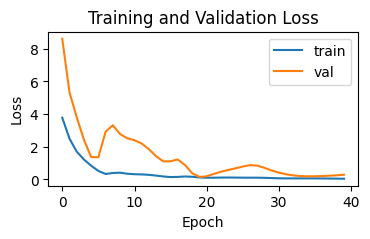

Test loss for 12: 0.5908910632133484
------------------------------Working on Simulation Data:  12 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 623
Best Val Loss after training: 0.0033548164647072554


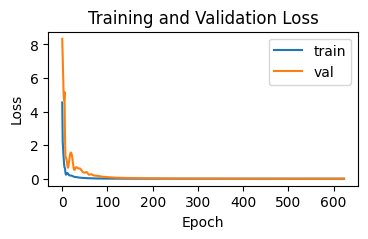

Test loss for 12: 0.015614284202456474
------------------------------Working on Simulation Data:  12 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 440
Best Val Loss after training: 0.0018175278091803193


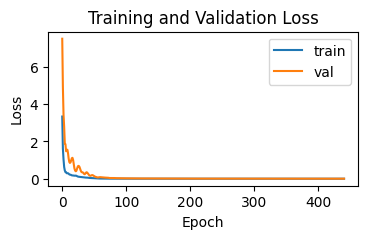

Test loss for 12: 0.0075247036293148994
------------------------------Working on Simulation Data:  12 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 613
Best Val Loss after training: 0.0037515168078243732


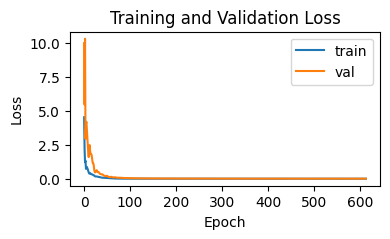

Test loss for 12: 0.015854494646191597
------------------------------Working on Simulation Data:  12 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 411
Best Val Loss after training: 0.0023590014316141605


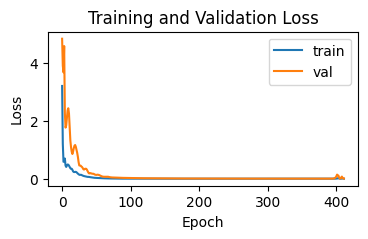

Test loss for 12: 0.011063110083341599
------------------------------Working on Simulation Data:  12 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 666
Best Val Loss after training: 0.002271081553772092


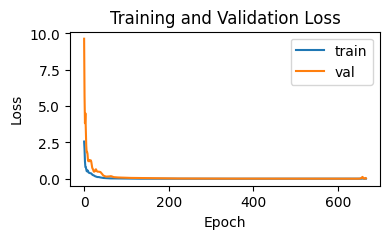

Test loss for 12: 0.04702011123299599
------------------------------Working on Simulation Data:  12 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 516
Best Val Loss after training: 0.002414554124698043


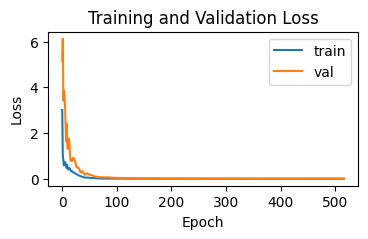

Test loss for 12: 0.011298634111881256
------------------------------Working on Simulation Data:  12 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 314
Best Val Loss after training: 0.0036053326912224293


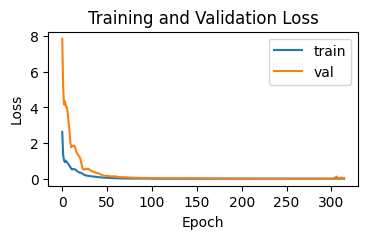

Test loss for 12: 0.06314527243375778
------------------------------Working on Simulation Data:  12 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 299
Best Val Loss after training: 0.004456632304936647


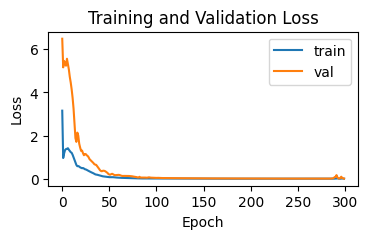

Test loss for 12: 0.017644349485635757
------------------------------Working on Simulation Data:  13 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 46
Best Val Loss after training: 0.3121340572834015


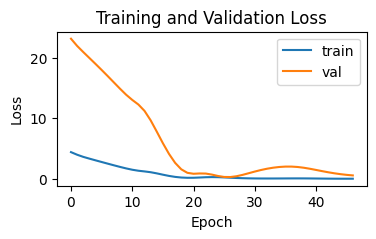

Test loss for 13: 2.3358092308044434
------------------------------Working on Simulation Data:  13 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 595
Best Val Loss after training: 0.005596194416284561


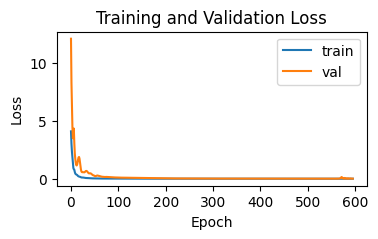

Test loss for 13: 0.024992430582642555
------------------------------Working on Simulation Data:  13 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 1039
Best Val Loss after training: 0.005907163489609957


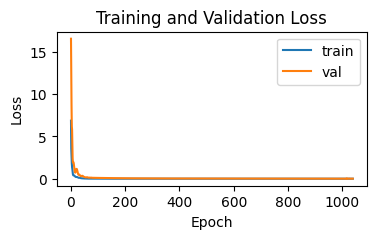

Test loss for 13: 0.060760948807001114
------------------------------Working on Simulation Data:  13 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 1057
Best Val Loss after training: 0.005416950676590204


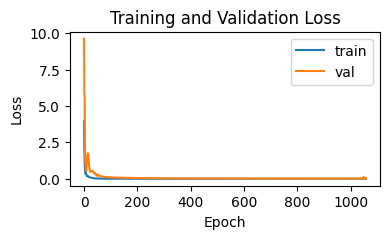

Test loss for 13: 0.09422976523637772
------------------------------Working on Simulation Data:  13 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 713
Best Val Loss after training: 0.00321879331022501


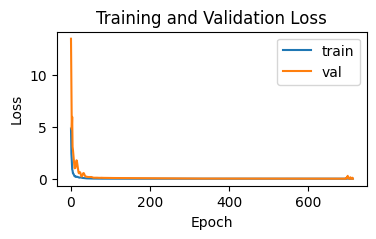

Test loss for 13: 0.024090729653835297
------------------------------Working on Simulation Data:  13 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 66
Best Val Loss after training: 0.10120730847120285


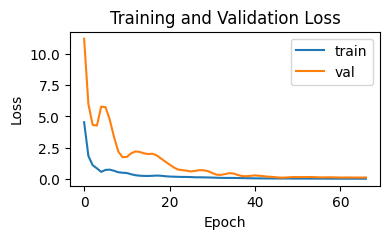

Test loss for 13: 0.4622630774974823
------------------------------Working on Simulation Data:  13 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 430
Best Val Loss after training: 0.00992655847221613


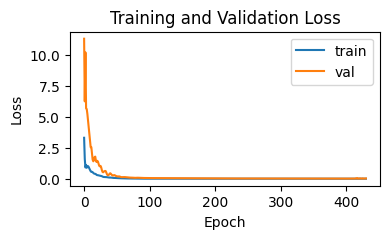

Test loss for 13: 0.09568160027265549
------------------------------Working on Simulation Data:  13 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 234
Best Val Loss after training: 0.021062292158603668


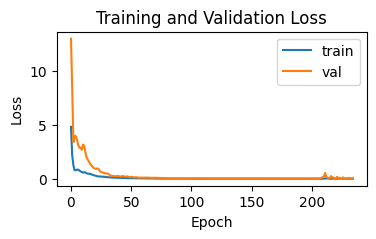

Test loss for 13: 0.2451298087835312
------------------------------Working on Simulation Data:  13 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 305
Best Val Loss after training: 0.025919923558831215


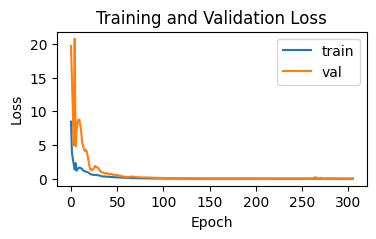

Test loss for 13: 0.14567776024341583
------------------------------Working on Simulation Data:  13 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 22
Best Val Loss after training: 4.825666427612305


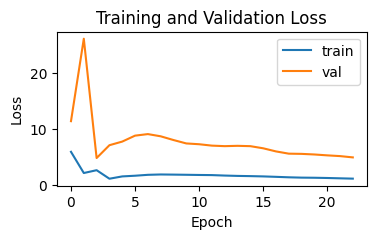

Test loss for 13: 7.266512393951416
------------------------------Working on Simulation Data:  14 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 1174
Best Val Loss after training: 0.012028043158352375


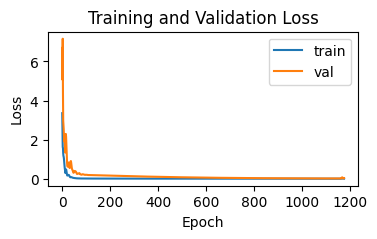

Test loss for 14: 0.08277148008346558
------------------------------Working on Simulation Data:  14 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Best Val Loss after training: 0.016458654776215553


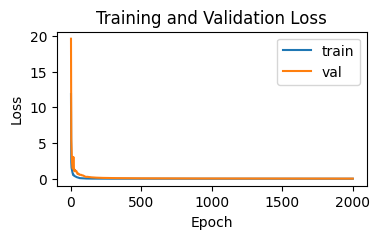

Test loss for 14: 0.03989898040890694
------------------------------Working on Simulation Data:  14 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 1282
Best Val Loss after training: 0.004810632206499577


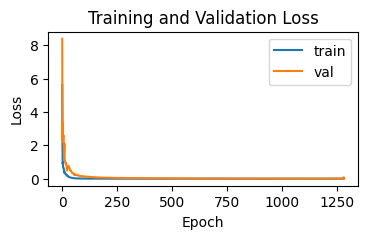

Test loss for 14: 0.07625041157007217
------------------------------Working on Simulation Data:  14 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 1393
Best Val Loss after training: 0.011363107711076736


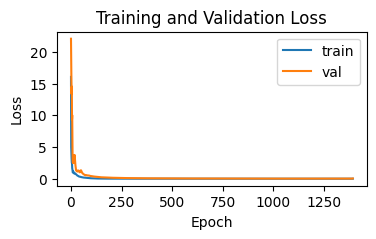

Test loss for 14: 0.08126051723957062
------------------------------Working on Simulation Data:  14 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 625
Best Val Loss after training: 0.006356739439070225


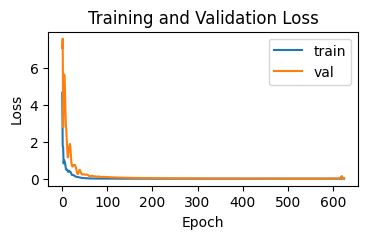

Test loss for 14: 0.07267764210700989
------------------------------Working on Simulation Data:  14 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 297
Best Val Loss after training: 0.02683795988559723


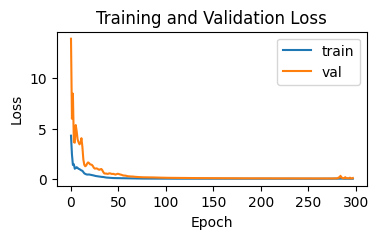

Test loss for 14: 0.16945472359657288
------------------------------Working on Simulation Data:  14 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 579
Best Val Loss after training: 0.014101587235927582


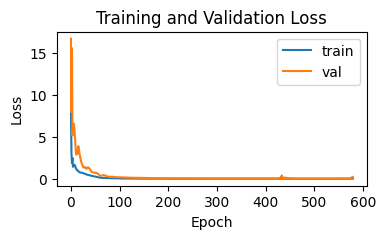

Test loss for 14: 0.31732937693595886
------------------------------Working on Simulation Data:  14 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 432
Best Val Loss after training: 0.019574342295527458


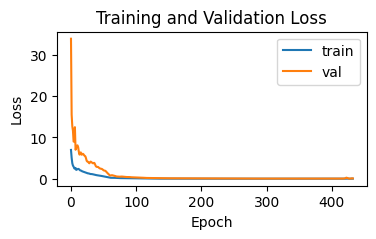

Test loss for 14: 0.16218987107276917
------------------------------Working on Simulation Data:  14 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 401
Best Val Loss after training: 0.03772859647870064


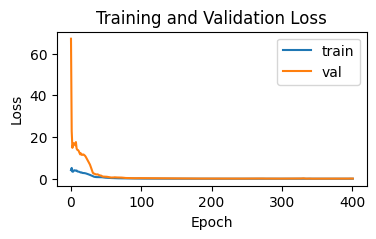

Test loss for 14: 0.16431650519371033
------------------------------Working on Simulation Data:  14 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 256
Best Val Loss after training: 0.28960710763931274


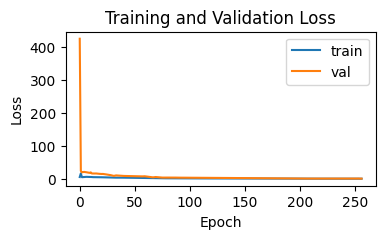

Test loss for 14: 0.71397864818573
------------------------------Working on Simulation Data:  15 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 694
Best Val Loss after training: 0.002720377640798688


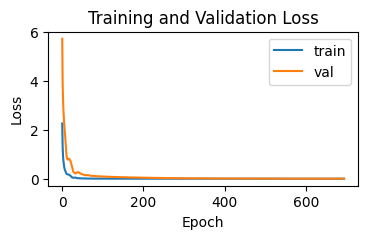

Test loss for 15: 0.012144122272729874
------------------------------Working on Simulation Data:  15 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 742
Best Val Loss after training: 0.001910185907036066


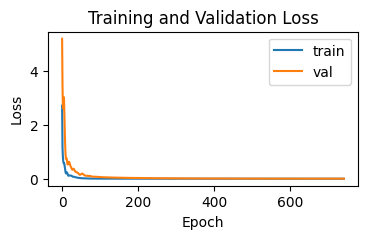

Test loss for 15: 0.006790940184146166
------------------------------Working on Simulation Data:  15 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 22
Best Val Loss after training: 1.5879665613174438


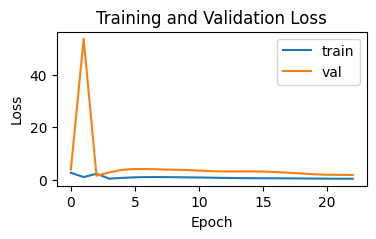

Test loss for 15: 2.380671739578247
------------------------------Working on Simulation Data:  15 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 436
Best Val Loss after training: 0.005275753792375326


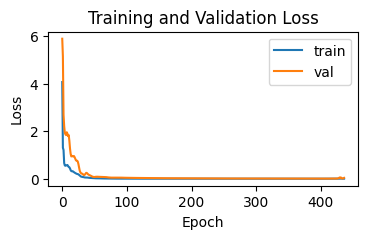

Test loss for 15: 0.06887353211641312
------------------------------Working on Simulation Data:  15 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 396
Best Val Loss after training: 0.00590983871370554


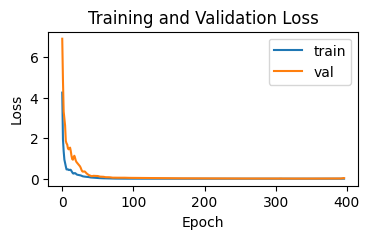

Test loss for 15: 0.04886721074581146
------------------------------Working on Simulation Data:  15 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 620
Best Val Loss after training: 0.022437410429120064


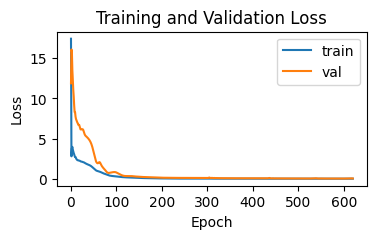

Test loss for 15: 0.058352030813694
------------------------------Working on Simulation Data:  15 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 321
Best Val Loss after training: 0.018285615369677544


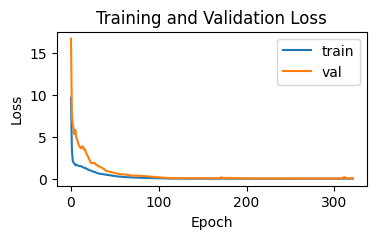

Test loss for 15: 0.05389293655753136
------------------------------Working on Simulation Data:  15 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 204
Best Val Loss after training: 0.02266329526901245


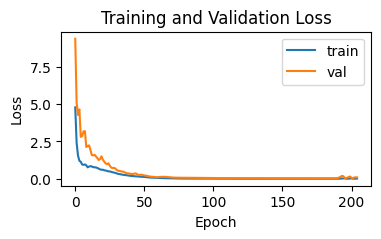

Test loss for 15: 0.14430999755859375
------------------------------Working on Simulation Data:  15 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 362
Best Val Loss after training: 0.008613056503236294


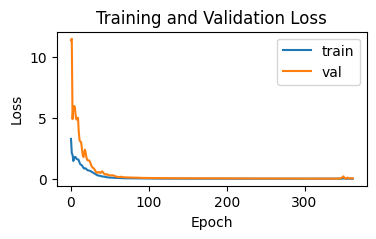

Test loss for 15: 0.039371442049741745
------------------------------Working on Simulation Data:  15 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 258
Best Val Loss after training: 0.01865333504974842


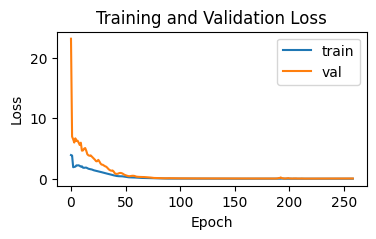

Test loss for 15: 0.08539453893899918
------------------------------Working on Simulation Data:  16 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 66
Best Val Loss after training: 0.09734873473644257


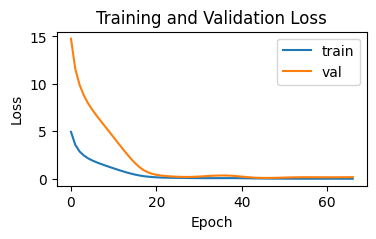

Test loss for 16: 0.3210689127445221
------------------------------Working on Simulation Data:  16 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 28
Best Val Loss after training: 0.4416947066783905


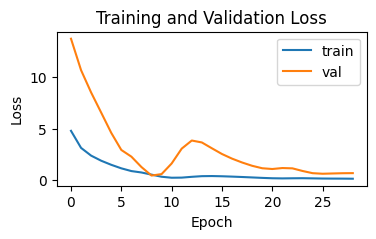

Test loss for 16: 1.3514304161071777
------------------------------Working on Simulation Data:  16 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 968
Best Val Loss after training: 0.0029308057855814695


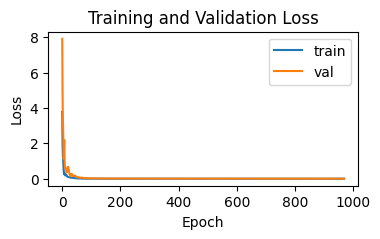

Test loss for 16: 0.009805596433579922
------------------------------Working on Simulation Data:  16 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 618
Best Val Loss after training: 0.0037735123187303543


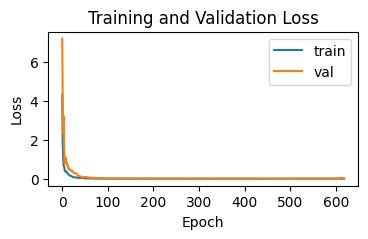

Test loss for 16: 0.03917555510997772
------------------------------Working on Simulation Data:  16 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 664
Best Val Loss after training: 0.008534982800483704


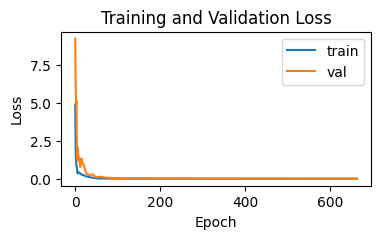

Test loss for 16: 0.04141593724489212
------------------------------Working on Simulation Data:  16 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 261
Best Val Loss after training: 0.010717754252254963


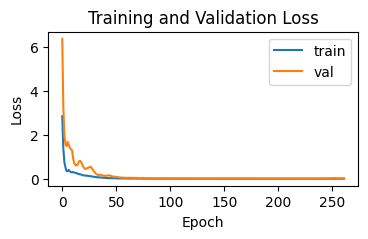

Test loss for 16: 0.057270348072052
------------------------------Working on Simulation Data:  16 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 289
Best Val Loss after training: 0.013207945041358471


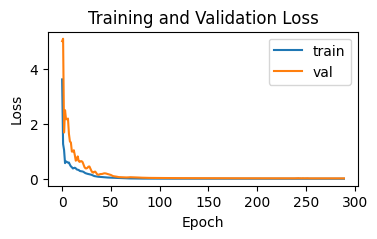

Test loss for 16: 0.05958648771047592
------------------------------Working on Simulation Data:  16 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 505
Best Val Loss after training: 0.007717227563261986


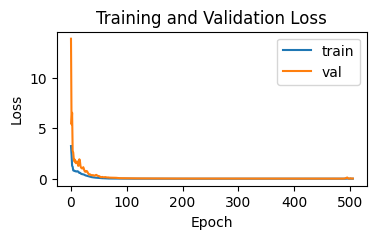

Test loss for 16: 0.05019831657409668
------------------------------Working on Simulation Data:  16 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 416
Best Val Loss after training: 0.010390798561275005


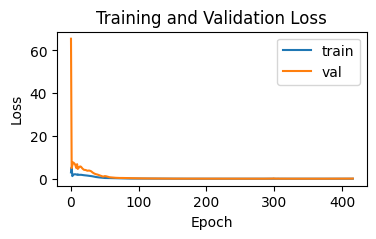

Test loss for 16: 0.15663224458694458
------------------------------Working on Simulation Data:  16 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 242
Best Val Loss after training: 0.009195840917527676


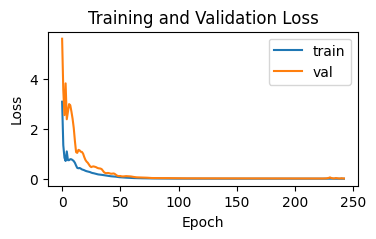

Test loss for 16: 0.03540479391813278
------------------------------Working on Simulation Data:  17 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 545
Best Val Loss after training: 0.004322914872318506


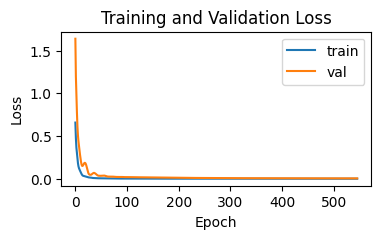

Test loss for 17: 0.016723183915019035
------------------------------Working on Simulation Data:  17 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 606
Best Val Loss after training: 0.004031408578157425


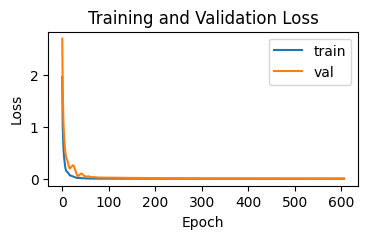

Test loss for 17: 0.014892194420099258
------------------------------Working on Simulation Data:  17 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 977
Best Val Loss after training: 0.004787691403180361


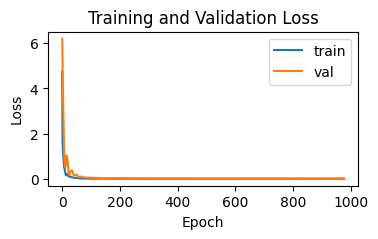

Test loss for 17: 0.02609286829829216
------------------------------Working on Simulation Data:  17 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 663
Best Val Loss after training: 0.004640995990484953


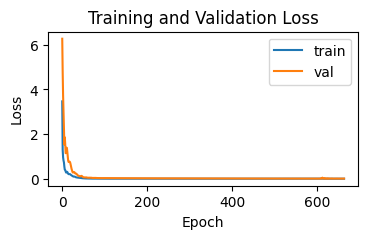

Test loss for 17: 0.028300225734710693
------------------------------Working on Simulation Data:  17 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 194
Best Val Loss after training: 0.05498122423887253


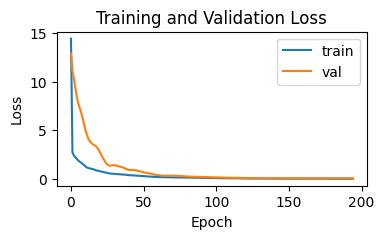

Test loss for 17: 0.13113822042942047
------------------------------Working on Simulation Data:  17 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 178
Best Val Loss after training: 0.027157548815011978


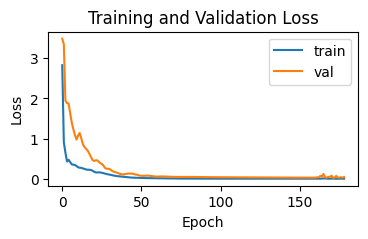

Test loss for 17: 0.1325433850288391
------------------------------Working on Simulation Data:  17 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 304
Best Val Loss after training: 0.012823573313653469


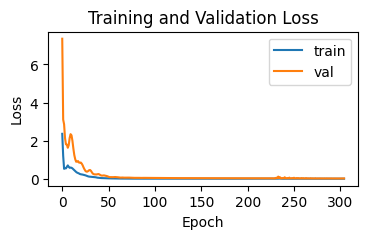

Test loss for 17: 0.05875951424241066
------------------------------Working on Simulation Data:  17 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 435
Best Val Loss after training: 0.014992302283644676


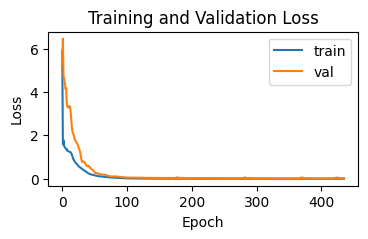

Test loss for 17: 0.07407958805561066
------------------------------Working on Simulation Data:  17 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 595
Best Val Loss after training: 0.018162768334150314


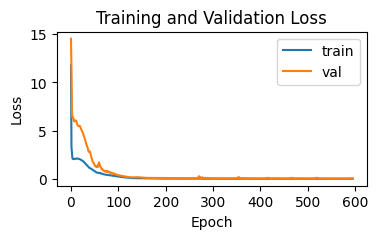

Test loss for 17: 0.06489945948123932
------------------------------Working on Simulation Data:  17 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 242
Best Val Loss after training: 0.07219772040843964


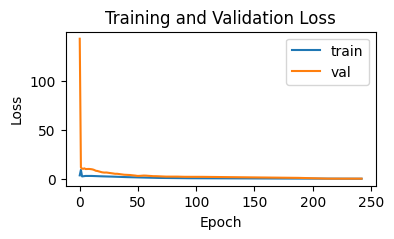

Test loss for 17: 0.1532004177570343
------------------------------Working on Simulation Data:  18 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 1662
Best Val Loss after training: 0.0045929886400699615


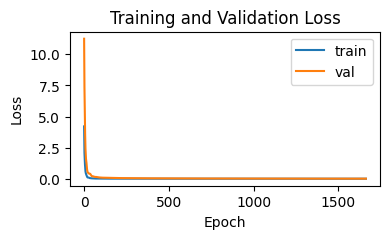

Test loss for 18: 0.02753080427646637
------------------------------Working on Simulation Data:  18 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 68
Best Val Loss after training: 0.07923149317502975


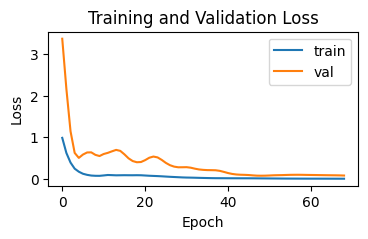

Test loss for 18: 0.23013532161712646
------------------------------Working on Simulation Data:  18 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 697
Best Val Loss after training: 0.005757538136094809


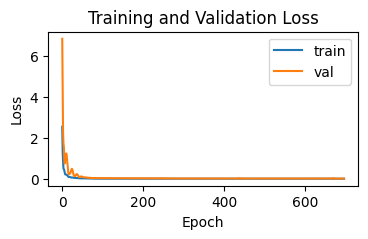

Test loss for 18: 0.03133738413453102
------------------------------Working on Simulation Data:  18 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 633
Best Val Loss after training: 0.013631407171487808


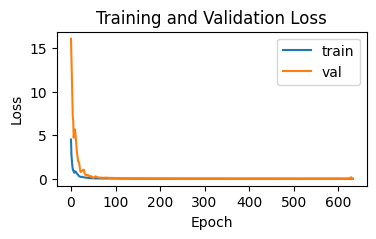

Test loss for 18: 0.07781089097261429
------------------------------Working on Simulation Data:  18 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 855
Best Val Loss after training: 0.017936579883098602


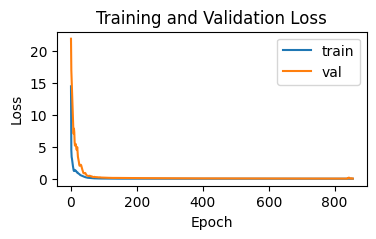

Test loss for 18: 0.1203644648194313
------------------------------Working on Simulation Data:  18 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 383
Best Val Loss after training: 0.06902935355901718


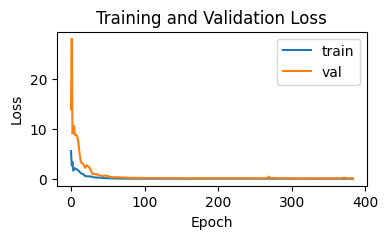

Test loss for 18: 0.37164485454559326
------------------------------Working on Simulation Data:  18 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 420
Best Val Loss after training: 0.021142948418855667


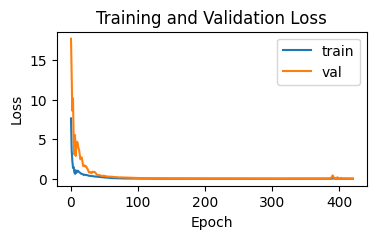

Test loss for 18: 0.11581926792860031
------------------------------Working on Simulation Data:  18 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 109
Best Val Loss after training: 0.19041505455970764


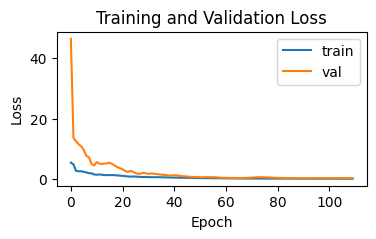

Test loss for 18: 0.7590762376785278
------------------------------Working on Simulation Data:  18 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 193
Best Val Loss after training: 0.8560875058174133


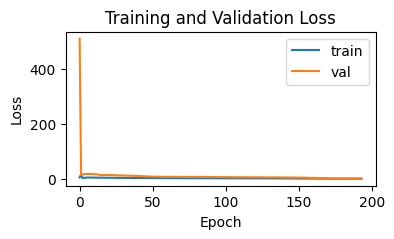

Test loss for 18: 1.7770543098449707
------------------------------Working on Simulation Data:  18 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 170
Best Val Loss after training: 2.0775809288024902


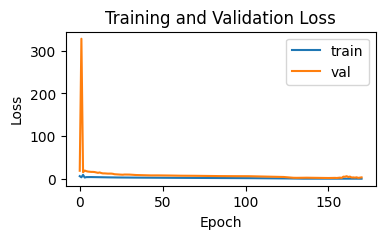

Test loss for 18: 6.1857805252075195
------------------------------Working on Simulation Data:  19 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Best Val Loss after training: 0.006319322623312473


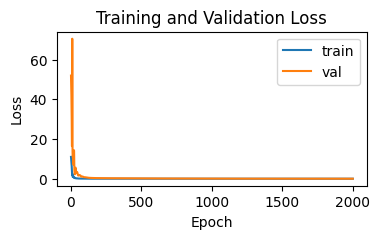

Test loss for 19: 0.05882440134882927
------------------------------Working on Simulation Data:  19 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 71
Best Val Loss after training: 0.18270045518875122


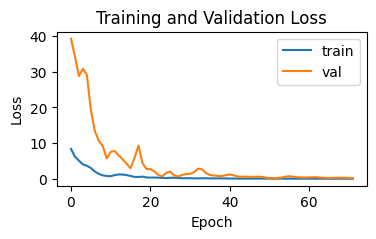

Test loss for 19: 0.6877204775810242
------------------------------Working on Simulation Data:  19 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 84
Best Val Loss after training: 0.054386455565690994


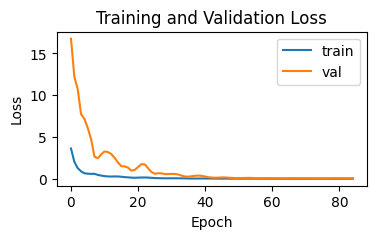

Test loss for 19: 0.2927834689617157
------------------------------Working on Simulation Data:  19 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 715
Best Val Loss after training: 0.03630589321255684


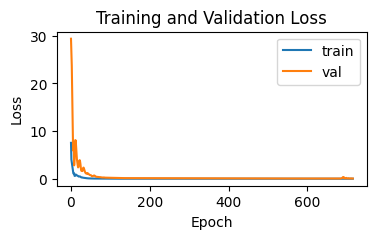

Test loss for 19: 0.30889222025871277
------------------------------Working on Simulation Data:  19 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 378
Best Val Loss after training: 0.046659499406814575


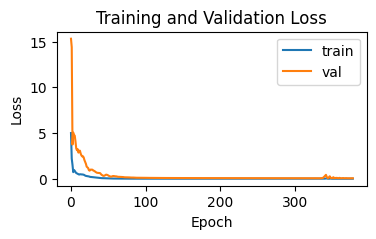

Test loss for 19: 0.4183770716190338
------------------------------Working on Simulation Data:  19 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 197
Best Val Loss after training: 0.06112073361873627


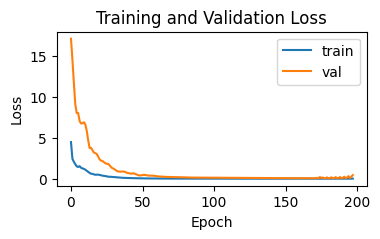

Test loss for 19: 1.4775960445404053
------------------------------Working on Simulation Data:  19 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 516
Best Val Loss after training: 0.04757770523428917


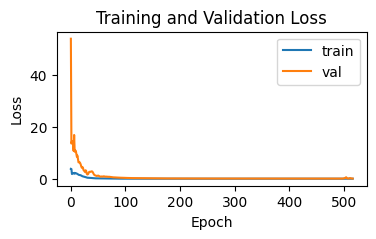

Test loss for 19: 0.3943387567996979
------------------------------Working on Simulation Data:  19 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 21
Best Val Loss after training: 16.215578079223633


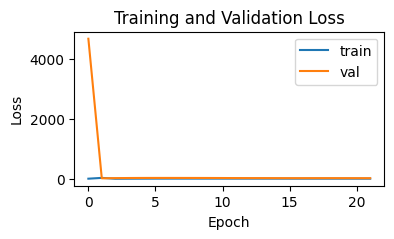

Test loss for 19: 28.433820724487305
------------------------------Working on Simulation Data:  19 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 161
Best Val Loss after training: 0.049834899604320526


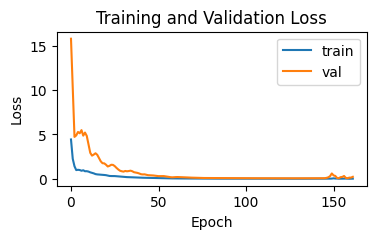

Test loss for 19: 0.7472097277641296
------------------------------Working on Simulation Data:  19 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 21
Best Val Loss after training: 15.045854568481445


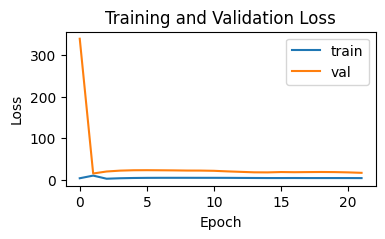

Test loss for 19: 24.213817596435547
------------------------------Working on Simulation Data:  20 with  10 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 10, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 80
Best Val Loss after training: 0.05786044895648956


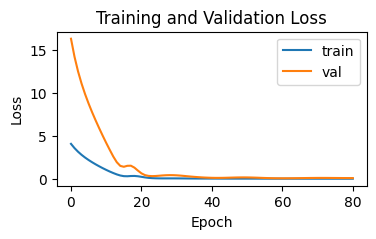

Test loss for 20: 0.23910541832447052
------------------------------Working on Simulation Data:  20 with  20 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 20, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 45
Best Val Loss after training: 0.2503969371318817


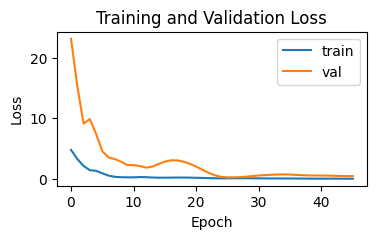

Test loss for 20: 1.3767145872116089
------------------------------Working on Simulation Data:  20 with  30 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 30, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 749
Best Val Loss after training: 0.00837674830108881


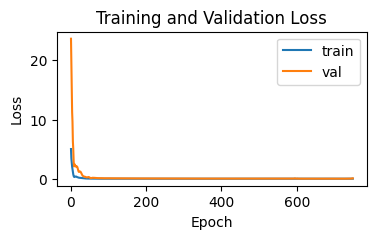

Test loss for 20: 0.12468091398477554
------------------------------Working on Simulation Data:  20 with  40 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 40, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 767
Best Val Loss after training: 0.0022830809466540813


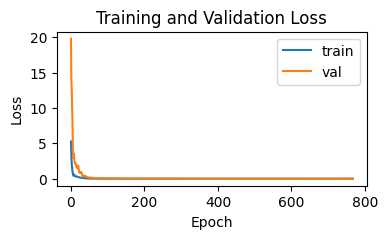

Test loss for 20: 0.06328495591878891
------------------------------Working on Simulation Data:  20 with  50 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 50, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 694
Best Val Loss after training: 0.014543374069035053


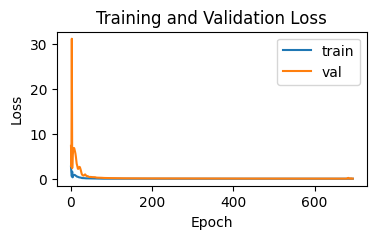

Test loss for 20: 0.07462085783481598
------------------------------Working on Simulation Data:  20 with  60 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 60, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 491
Best Val Loss after training: 0.017547881230711937


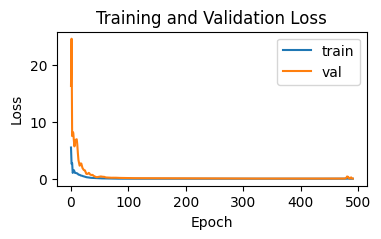

Test loss for 20: 0.0907500684261322
------------------------------Working on Simulation Data:  20 with  70 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 70, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 209
Best Val Loss after training: 0.041299428790807724


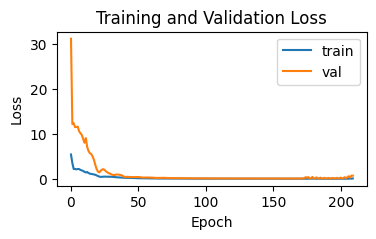

Test loss for 20: 1.489688515663147
------------------------------Working on Simulation Data:  20 with  80 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 80, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 91
Best Val Loss after training: 0.15665972232818604


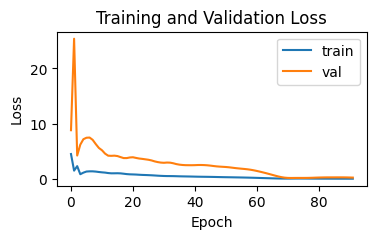

Test loss for 20: 0.6847745776176453
------------------------------Working on Simulation Data:  20 with  90 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 90, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 269
Best Val Loss after training: 0.03198402747511864


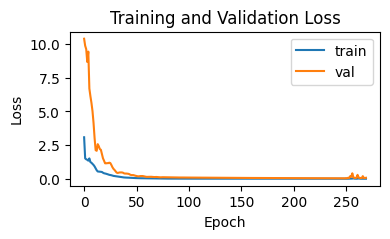

Test loss for 20: 0.24965493381023407
------------------------------Working on Simulation Data:  20 with  100 species-------------------------------------------
Training with batch_time=179, batch_size=1, lr=0.01
Model args: (5, 100, 0.002)


  0%|          | 0/2001 [00:00<?, ?it/s]

Early stopping at epoch 292
Best Val Loss after training: 0.03391355276107788


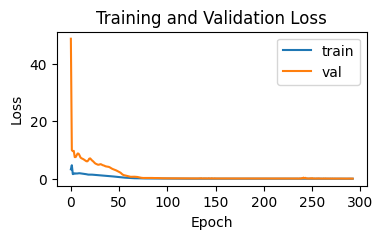

Test loss for 20: 0.16815093159675598


In [ ]:
deltas = {}

test_time_points = 10
val_time_points = 10


for sim_data in [12, 13, 14, 15, 16, 17, 18, 19, 20]:

  result = sim_results[sim_data]

  e = result['e'].transpose(0, 1)
  x_all = result['pred_y'].squeeze(1)
  t = result['t']

  n = e.shape[1]

  if sim_data not in deltas:
    deltas[sim_data] = {}

  for m in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:

    x = x_all[:,:m]

    train_time_points = x.shape[0] - val_time_points - test_time_points

    train_x, val_x, test_x, train_e, val_e, test_e = data_split(x, e, test_time_points, val_time_points)

    t_train = t[ : train_time_points]
    t_val = t[ : train_time_points + val_time_points]
    t_test = t[ : train_time_points + val_time_points + test_time_points]

    print("------------------------------Working on Simulation Data: ", sim_data, "with ", m, "species-------------------------------------------")

    # Define hyperparameters
    hyperparameters = [
        (train_time_points-1, 1, 0.01),]  # (batch_time, batch_size, learning_rate)

    best_model_state, best_hyperparams, best_val_loss = train_and_optimize_model(CombinedODEModel,
                             hyperparameters,
                             get_batch, train_x, train_e,
                             x, e, t_val, train_time_points, val_time_points, val_x,
                             niters=2000, early_stopping_patience=20, early_stopping_min_delta=1e-4, model_args=(n,m,0.0020))

    # Load the best model state
    best_model = CombinedODEModel(n, m, 0.0020)
    best_model.load_state_dict(best_model_state)
    best_model.eval()

    # Predict the test data
    with torch.no_grad():
      best_model.set_control_variables(e.unsqueeze(1))
      y_pred_test = odeint_adjoint(best_model, x.unsqueeze(1)[0, :, :], t_test, rtol=1e-3, atol=1e-4, method='euler')
      test_loss = torch.mean(torch.square(y_pred_test[train_time_points + val_time_points:, :, :] - test_x.unsqueeze(1)))

    print(f"Test loss for {sim_data}: {test_loss.item()}")

    # Ensure the nested dictionary for `m` is created
    if m not in deltas[sim_data]:
      deltas[sim_data][m] = {}

    # Find parameter delta
    with torch.no_grad():
      deltas[sim_data][m] = {
                'weight_1_delta': torch.sum(torch.square(best_model.net_1.weight - result['weight_net_1'][:m,:])).item() / torch.sum(torch.square(result['weight_net_1'][:m,:])).item(),
                'bias_1_delta': torch.sum(torch.square(best_model.net_1.bias - result['bias_net_1'][:m])).item() / torch.sum(torch.square(result['bias_net_1'][:m])).item(),
                'weight_2_delta': torch.sum(torch.square(best_model.net_2.weight - result['weight_net_2'][:m,:m])).item() / torch.sum(torch.square(result['weight_net_2'][:m,:m])).item()
                }

In [ ]:
deltas

{12: {10: {'weight_1_delta': 6.428637239553662,
   'bias_1_delta': 11.038033089129643,
   'weight_2_delta': 4.991950238080627},
  20: {'weight_1_delta': 9.38858035160962,
   'bias_1_delta': 5.141942112945326,
   'weight_2_delta': 2.703969092707644},
  30: {'weight_1_delta': 7.792952242070597,
   'bias_1_delta': 15.065443401707308,
   'weight_2_delta': 2.1735220897566023},
  40: {'weight_1_delta': 6.781917836059989,
   'bias_1_delta': 6.993985333479864,
   'weight_2_delta': 1.8811936296402905},
  50: {'weight_1_delta': 6.943089945196345,
   'bias_1_delta': 7.705003037280709,
   'weight_2_delta': 1.5885617047538327},
  60: {'weight_1_delta': 7.042325042565826,
   'bias_1_delta': 6.444952564563204,
   'weight_2_delta': 1.5727463137087132},
  70: {'weight_1_delta': 6.957334147812262,
   'bias_1_delta': 8.131141597413512,
   'weight_2_delta': 1.4877209049117606},
  80: {'weight_1_delta': 6.95886854041376,
   'bias_1_delta': 7.0978035895091764,
   'weight_2_delta': 1.408703504847588},
  90: 

In [ ]:
import pickle

# Save the dictionary to a file
with open('parameter_delta_species_change_from_sim_12_to_sim_20.pkl', 'wb') as f:
    pickle.dump(deltas, f)

print("Dictionary saved to 'parameter_delta_species_change_from_sim_12_to_sim_20.pkl'")

Dictionary saved to 'parameter_delta_species_change_from_sim_12_to_sim_20.pkl'


In [ ]:
import pickle
# Load the dictionary from the pickle file
with open('/content/parameter_delta_species_change_upto_sim_5.pkl', 'rb') as f:
    deltas_1 = pickle.load(f)

In [ ]:
# Load the dictionary from the pickle file
with open('/content/parameter_delta_species_change_from_sim_6_to_sim_11.pkl', 'rb') as f:
    deltas_2 = pickle.load(f)

In [ ]:
# Load the dictionary from the pickle file
with open('/content/parameter_delta_species_change_from_sim_12_to_sim_20.pkl', 'rb') as f:
    deltas_3 = pickle.load(f)

In [ ]:
deltas_1.update(deltas_2)
deltas_1.update(deltas_3)

In [ ]:
deltas_1.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [ ]:
deltas = deltas_1

In [ ]:
import pickle

# Save the dictionary to a file
with open('parameter_delta_species_change.pkl', 'wb') as f:
    pickle.dump(deltas, f)

print("Dictionary saved to 'parameter_delta_species_change.pkl'")

Dictionary saved to 'parameter_delta_species_change.pkl'


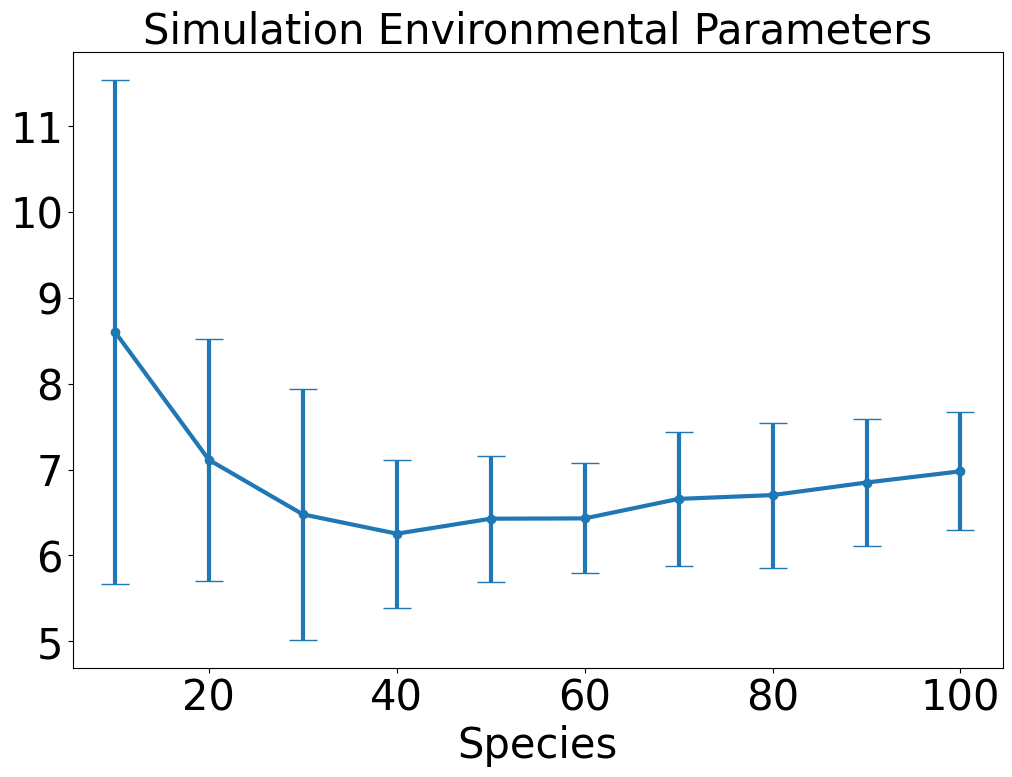

In [ ]:
m_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
weight_1_deltas = {m: [] for m in m_values}

# Collect the weight_1_delta for each d and sim_data
for sim_data in deltas:
    for m in m_values:
        if m in deltas[sim_data]:
            weight_1_deltas[m].append(deltas[sim_data][m]['weight_1_delta'])

# Calculate mean and standard deviation for each d
means = [np.mean(weight_1_deltas[m]) for m in m_values]
std_devs = [np.std(weight_1_deltas[m]) for m in m_values]

# Plotting the results
plt.figure(figsize=(12, 8))
plt.errorbar(m_values, means, yerr=std_devs, fmt='-o', capsize=10, linewidth=3)
plt.xlabel('Species', fontsize=30)
#plt.ylabel('Weight_e Delta', fontsize=30)
plt.title('Simulation Environmental Parameters', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.grid(True)
plt.show()

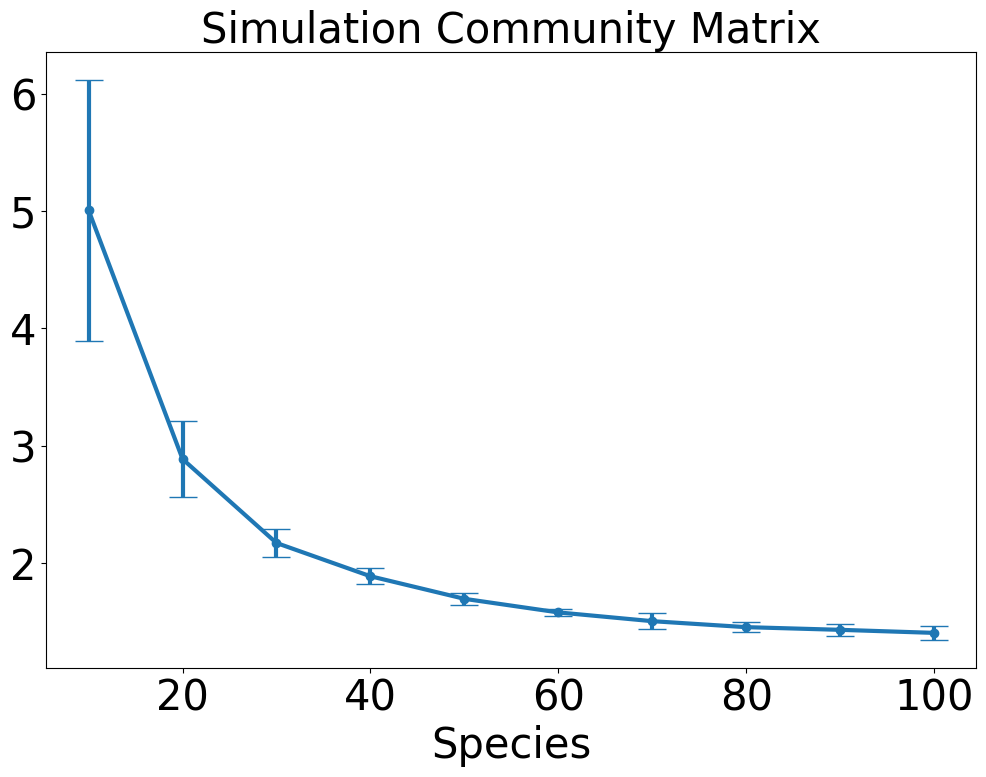

In [ ]:
m_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
weight_2_deltas = {m: [] for m in m_values}

# Collect the weight_1_delta for each d and sim_data
for sim_data in deltas:
    for m in m_values:
        if m in deltas[sim_data]:
            weight_2_deltas[m].append(deltas[sim_data][m]['weight_2_delta'])

# Calculate mean and standard deviation for each d
means = [np.mean(weight_2_deltas[m]) for m in m_values]
std_devs = [np.std(weight_2_deltas[m]) for m in m_values]

# Plotting the results
plt.figure(figsize=(12, 8))
plt.errorbar(m_values, means, yerr=std_devs, fmt='-o', capsize=10, linewidth=3)
plt.xlabel('Species', fontsize=30)
#plt.ylabel('A Delta', fontsize=24)
plt.title('Simulation Community Matrix', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.grid(True)
plt.show()

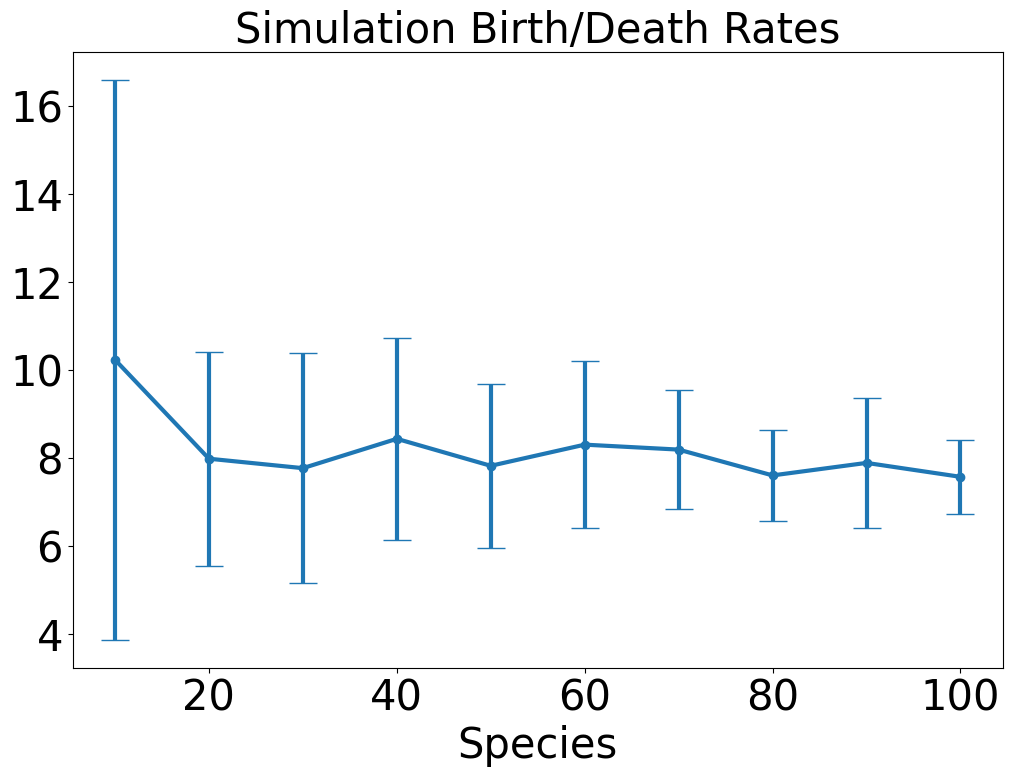

In [ ]:
m_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bias_1_deltas = {m: [] for m in m_values}

# Collect the weight_1_delta for each d and sim_data
for sim_data in deltas:
    for m in m_values:
        if m in deltas[sim_data]:
            bias_1_deltas[m].append(deltas[sim_data][m]['bias_1_delta'])

# Calculate mean and standard deviation for each d
means = [np.mean(bias_1_deltas[m]) for m in m_values]
std_devs = [np.std(bias_1_deltas[m]) for m in m_values]

# Plotting the results
plt.figure(figsize=(12, 8))
plt.errorbar(m_values, means, yerr=std_devs, fmt='-o', capsize=10, linewidth=3)
plt.xlabel('Species', fontsize=30)
#plt.ylabel('Birth/Death Rates Delta', fontsize=24)
plt.title('Simulation Birth/Death Rates', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.grid(True)
plt.show()